# TTT4275 Classification Project - Iris

This is the hand-in code for digits part of the TTT4275 classification project for group 60.

### Importing useful libraries and functions

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Part 1 - classifying using all features

#### Loading the data

In [9]:
feature_names=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
target_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
iris_df = pd.read_csv('./Iris_TTT4275/iris.data', names=[*feature_names, 'target'])

iris_data = iris_df.iloc[:, :4].values
iris_targets = iris_df['target'].values

### Implementing the linear classifier

In [41]:
class MSELinearClassifier:
    def __init__(self, alpha = 0.01, n_iter = 10000, threshold = 1e-3):
        self.alpha = alpha
        self.n_iter = n_iter
        self.threshold = threshold
        self.fitted = False

    def fit(self, data, targets):
        """
        Fit a linear classifier to the provided data.

        data: shape N x n_features
        targets: shape N
        """
        if data.ndim == 1:
            data = data[:, np.newaxis]


        self.fitted = True
        
        self.target_set = list(set(targets)) #to use .index() function we wrap as list
        self.n_classes = len(self.target_set)
        self.n_features = data.shape[1]
        N = data.shape[0]

        one_hot_targets = self._one_hot_encode_targets(targets)

        self.w = np.zeros((self.n_classes, self.n_features))
        self.offset = np.zeros(self.n_classes)

        data1 = np.hstack([data, np.ones((N,1))])

        pred = self.predict(data)
        for iter in range(self.n_iter):        
            
            grad_part1 = (pred - one_hot_targets)*pred*(1 - pred)

            # gradient = 0
            # for k in range(N):
            #     gradient += np.outer(grad_part1[k], data1[k])

            gradient = np.einsum('ij,ik -> jk', grad_part1, data1) #this vectorizes the above loop
            
            update = -self.alpha*gradient

            self.w += update[:, :-1]
            self.offset += update[:, -1]

            pred = self.predict(data)

            if np.linalg.norm(update) < self.threshold:
                print(f"Fitting converged after {iter} iterations.")
                break
            
        loss = self.loss(pred, one_hot_targets)
        return loss
    

    def _one_hot_encode_targets(self, targets):
        """
        Converts the labels in targets into one-hot encoded vectors

        targets: label of each sample
        """
        encoded = np.zeros((targets.shape[0], self.n_classes))

        for i in range(targets.shape[0]): #not neccessarily integer labels
            j = self.target_set.index(targets[i])
            encoded[i, j] = 1

        return encoded
    
    def _sigmoid(self, x):
        return 1/(1 + np.exp(-x))

    def predict(self, data, get_class = False):
        """
        Predicts using the weight matrix.

        Returns:
        Vector with a 0-1 score for each class, for each sample

        """
        if data.ndim == 1:
            data = data[:, np.newaxis]
            
        if not self.fitted:
            raise RuntimeError("The model must be fitted before predictions can be made")
        
        one_hot_preds = self._sigmoid(self.w@data.T + self.offset[:, np.newaxis]).T

        if get_class:
            return self.get_class(one_hot_preds)
        
        return one_hot_preds
    
    def loss(self, pred, truth):
        """
        Returns the MSE.
        """
        return 0.5*np.sum((pred - truth)**2)
    
    def get_class(self, predicted):
        targets = np.array(self.target_set)
        return targets[np.argmax(predicted, axis=1)]
    
    def score(self, test_data, test_labels):
        """
        Returns proportion of correct predictions on the test data and labels given.        
        """
        N = len(test_labels)
        preds = self.predict(test_data, get_class=True)
        return np.count_nonzero(test_labels == preds)/N


### Function for plotting confusion matrix

In [11]:
def plot_confusion_matrix(conf_matrix, score = None, plot = True, filename = None):    
    plt.figure(figsize=(6,6)) #size in inches
    sns.heatmap(conf_matrix, annot=True, linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual label', size=15)
    plt.xlabel('Predicted label', size=15)
    if score is not None:
        plt.title('Accuracy Score: {fscore:.{precision}f}%'.format(fscore = score*100, precision = 1), size = 20)
    if filename is not None:
        plt.savefig(filename)
    if plot:
        plt.show()
    plt.close()

### Choose the first 30 samples for training and the last 20 samples for testing

In [12]:
def split_iris_dataset(iris_data, iris_targets, train_size):

    if iris_data.ndim == 1:
        iris_data = iris_data[:, np.newaxis]
        
    training_data = np.concatenate((iris_data[0:train_size,:], iris_data[50:50+train_size,:], iris_data[100:100+train_size,:]))
    test_data = np.concatenate((iris_data[train_size:50,:], iris_data[50+train_size:100,:], iris_data[100+train_size:150,:]))

    training_labels = np.concatenate((iris_targets[0:train_size], iris_targets[50:50+train_size], iris_targets[100:100+train_size]))
    test_labels = np.concatenate((iris_targets[train_size:50], iris_targets[50+train_size:100], iris_targets[100+train_size:150]))

    return training_data, test_data, training_labels, test_labels

training_data, test_data, training_labels, test_labels = split_iris_dataset(iris_data, iris_targets, train_size = 30)

### Train and test the classifier

Fitting converged after 3012 iterations.
[[-3.26453948 -2.81206872  4.79047933  4.33684195]
 [ 1.47385528 -3.06707865 -0.26819499 -1.03634412]
 [ 0.45031122  1.78328751 -2.64884848 -1.2298472 ]] [-2.33173247  2.15280619  0.32036136]


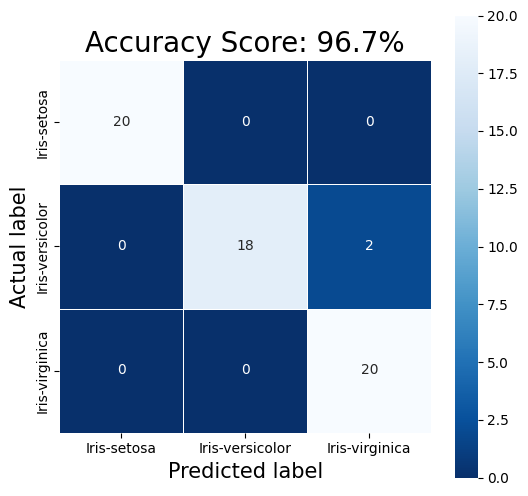

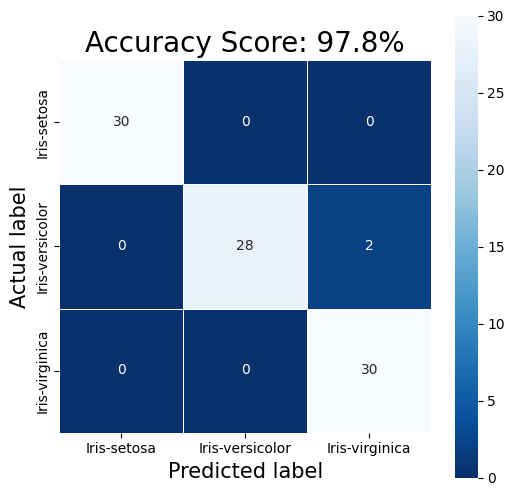

In [13]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score)

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score)

### Now use the last 30 samples for training and the first 20 samples for test.

In [14]:
training_data = np.concatenate((iris_data[20:50,:], iris_data[70:100,:], iris_data[120:150,:]))
test_data = np.concatenate((iris_data[0:20,:], iris_data[50:70,:], iris_data[100:120,:]))

training_labels = np.concatenate((iris_targets[20:50], iris_targets[70:100], iris_targets[120:150]))
test_labels = np.concatenate((iris_targets[0:20], iris_targets[50:70], iris_targets[100:120]))

### Train and test the linear classfier

Fitting converged after 4569 iterations.
[[-2.52860582 -3.60725477  4.27993385  5.45653848]
 [ 0.58106871  1.80267844 -2.85510996 -1.28177515]
 [-0.15768086 -1.929519    0.92246094 -2.12549335]] [-3.6708491   0.36241225  4.72759446]


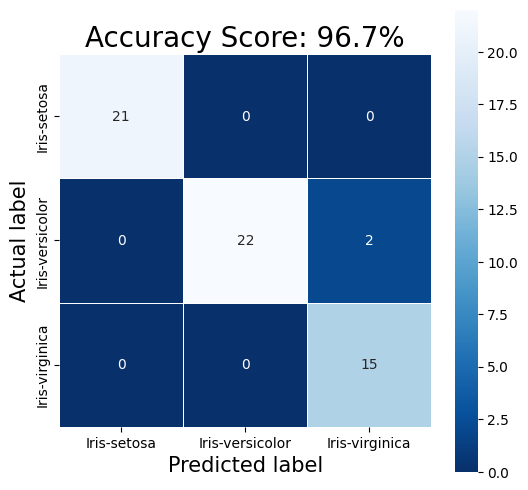

0.9666666666666667


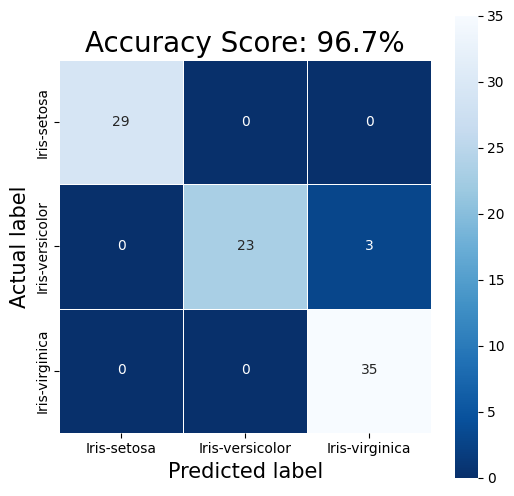

In [40]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score)

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score)

## Part 2

### Histogram of flowers per feature

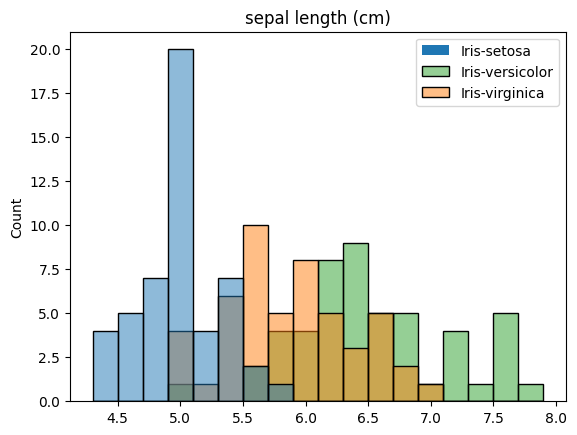

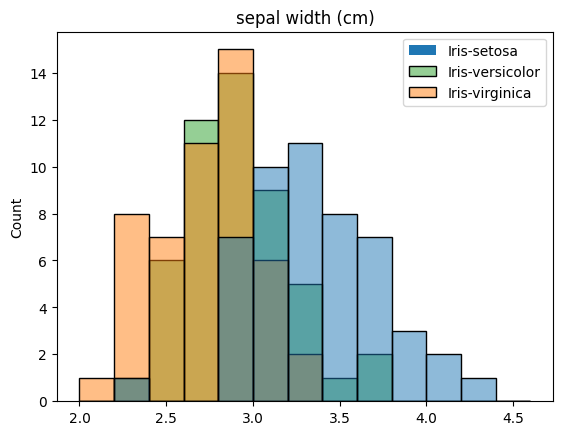

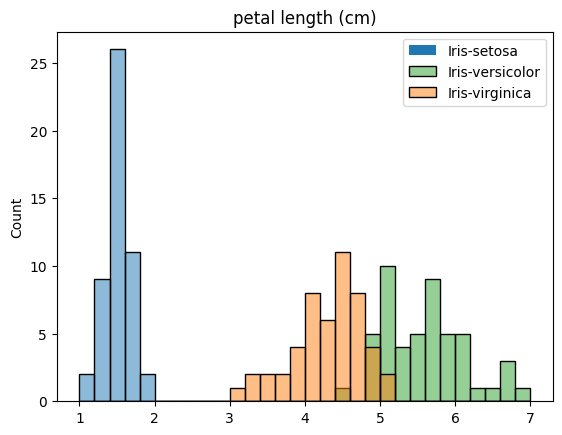

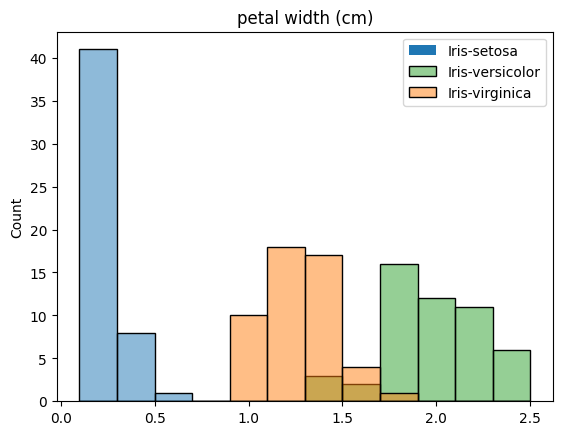

In [16]:
for i in range(len(feature_names)):
    sns.histplot(iris_data[:, i].reshape(3, 50).T, binwidth=0.2)
    plt.legend(target_names)
    plt.title(feature_names[i])
    plt.show()

### Histogram of feature per flower, less informative than plots above

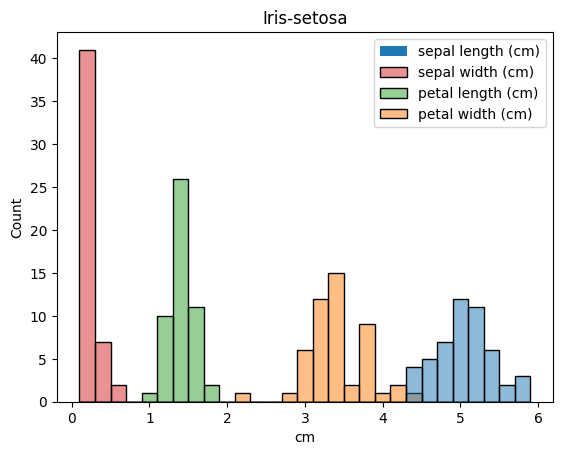

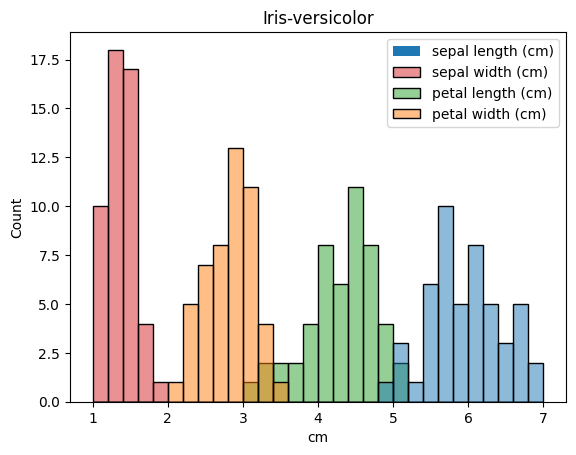

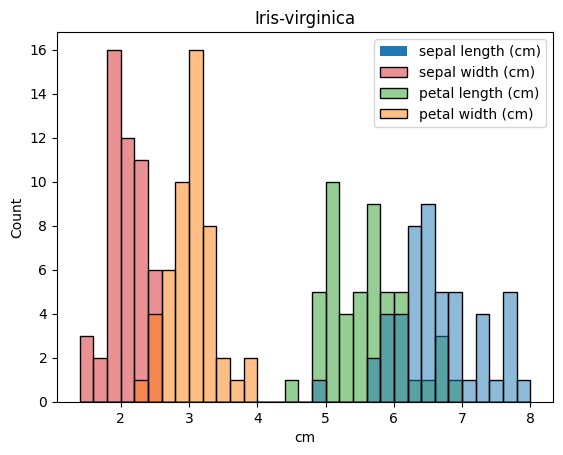

In [17]:
for tn in target_names:
    sns.histplot(iris_data[iris_targets == tn], binwidth=0.2)
    plt.legend(feature_names)
    plt.title(tn)
    plt.xlabel("cm")
    plt.show()

#### Feature 'sepal width' showing the most overlap. Remove it

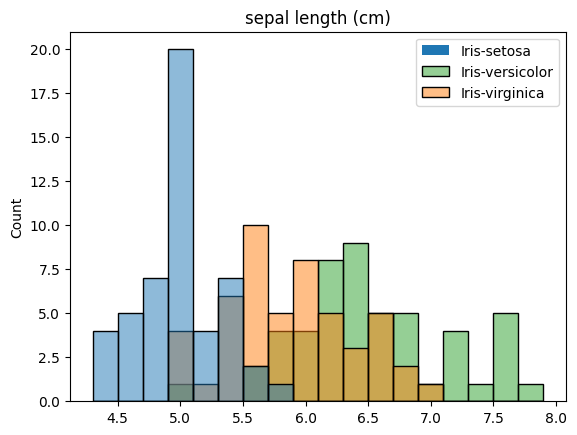

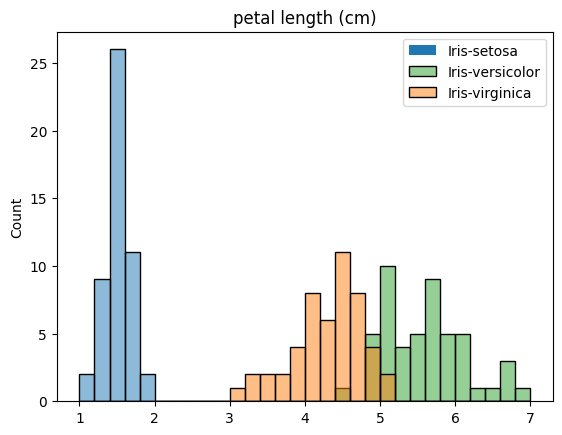

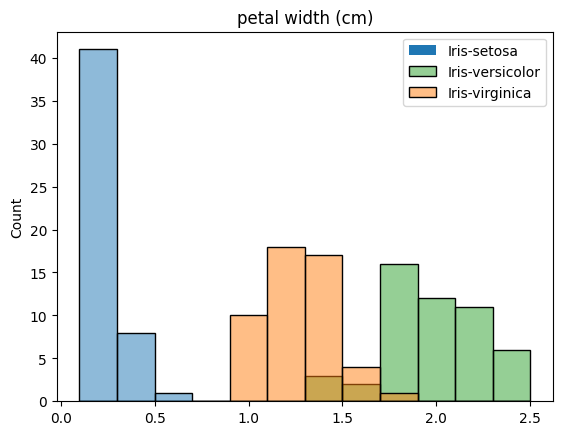

In [18]:
reduced_data = np.delete(iris_data, 1, 1)
reduced_feature_names = np.delete(feature_names, 1, 0)

for i in range(len(reduced_feature_names)):
    sns.histplot(reduced_data[:, i].reshape(3, 50).T, binwidth=0.2)
    plt.legend(target_names)
    plt.title(reduced_feature_names[i])
    plt.show()

### Split the reduced data - Choose the first 30 samples for training and the last 20 samples for testing

In [19]:
training_data, test_data, training_labels, test_labels = split_iris_dataset(reduced_data, iris_targets, train_size=30)

### Train and test the classifier

[[-5.04458306  6.14439924  4.66506643]
 [-0.88064582  1.77221568 -2.98690418]
 [ 2.06484211 -3.89268238 -1.8971645 ]] [-6.28938237  1.13950512  0.82725294]


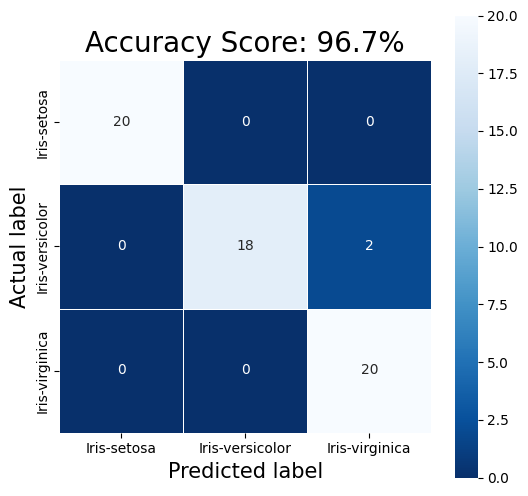

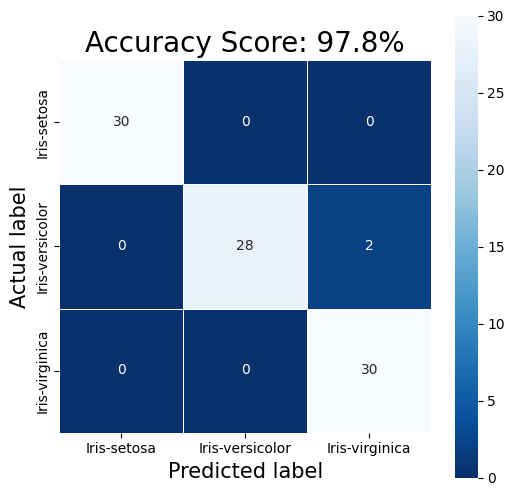

In [20]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

### Sepal length overlapping. Remove it

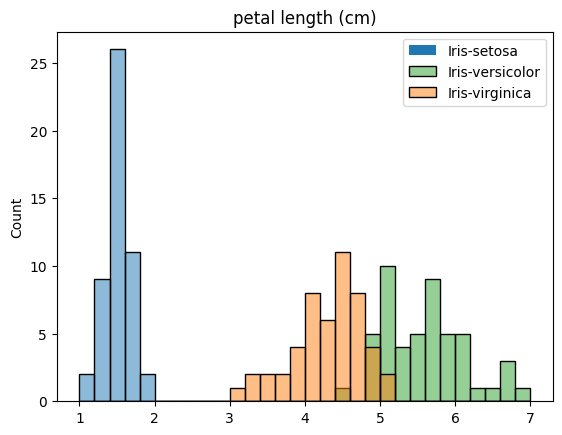

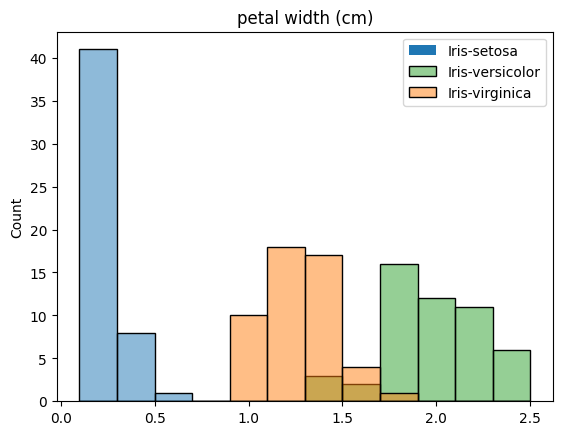

In [21]:
reduced_data2 = np.delete(reduced_data, 0, 1)
reduced_feature_names2 = np.delete(reduced_feature_names, 0, 0)

for i in range(len(reduced_feature_names2)):
    sns.histplot(reduced_data2[:, i].reshape(3, 50).T, binwidth=0.2)
    plt.legend(target_names)
    plt.title(reduced_feature_names2[i])
    plt.show()

### Split the reduced data - Choose the first 30 samples for training and the last 20 samples for testing 
This data now only has two features - petal length and petal width 

In [22]:
training_data, test_data, training_labels, test_labels = split_iris_dataset(reduced_data2, iris_targets, train_size=30)

### Train and test the classifier

Fitting converged after 4823 iterations.
[[ 0.67935752  5.05772456]
 [ 1.21553033 -2.45264186]
 [-1.83839103 -2.75101745]] [-11.71815443  -2.31099999   6.71317719]


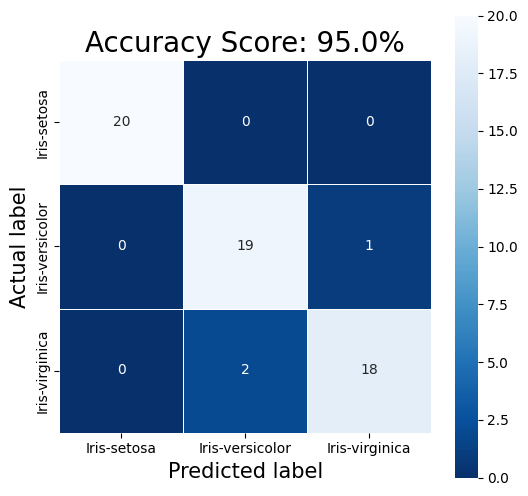

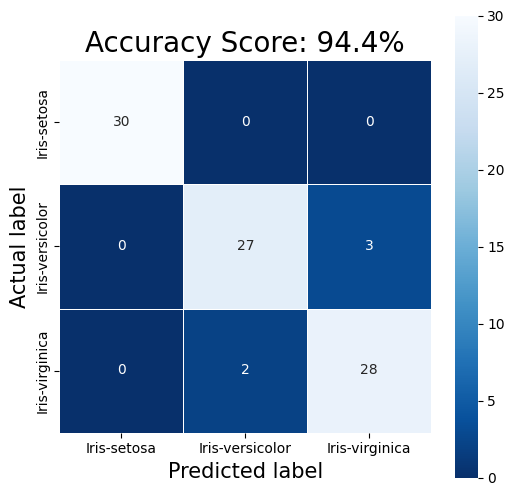

In [23]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)

pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

### Train on only one feature, test both petal width and length

In [24]:
training_data, test_data, training_labels, test_labels = split_iris_dataset(iris_data[:,2], iris_targets, train_size=30)

### Train on petal length

Fitting converged after 5105 iterations.
[[ 2.57266967]
 [ 0.18325156]
 [-2.84945856]] [-12.62123987  -1.37240878   7.47091935]


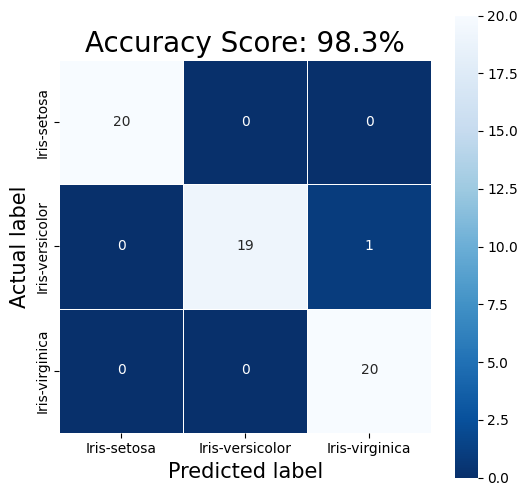

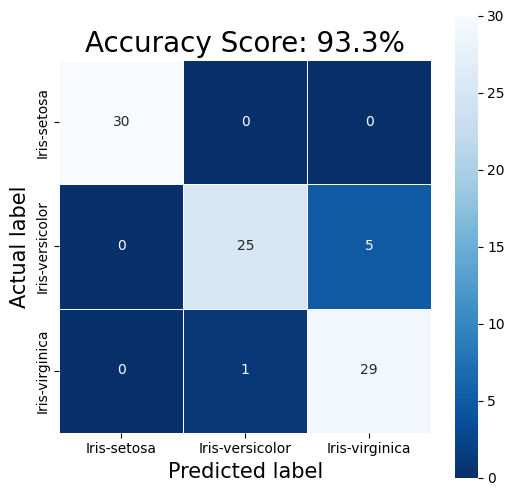

In [25]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

In [26]:
training_data, test_data, training_labels, test_labels = split_iris_dataset(iris_data[:,3], iris_targets, train_size=30)

### Train on petal width

Fitting converged after 4597 iterations.
[[ 6.34221763]
 [ 0.28291084]
 [-7.01000349]] [-10.47878391  -1.02448386   5.01043798]


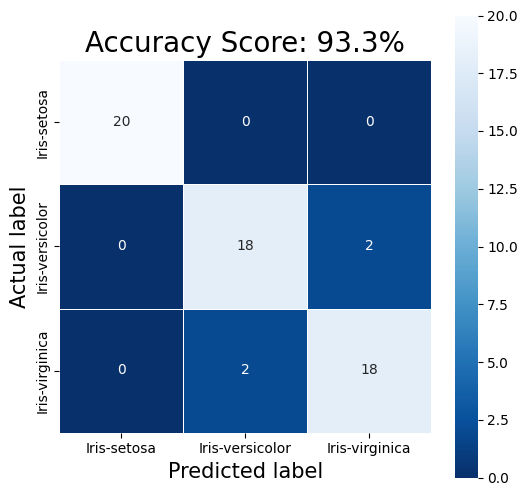

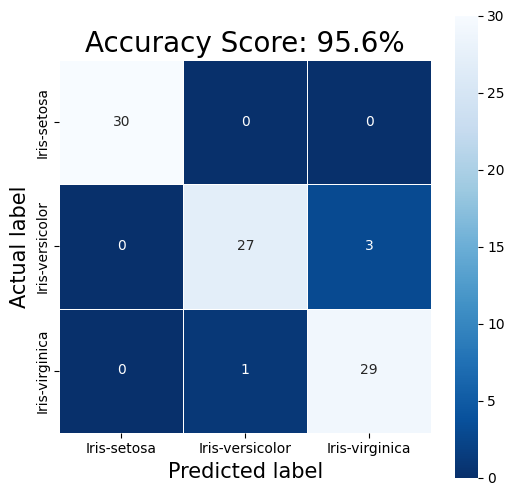

In [27]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

### To compare, here trained on presumed worst feature, sepal width

In [28]:
training_data, test_data, training_labels, test_labels = split_iris_dataset(iris_data[:,1], iris_targets, train_size=30)

Fitting converged after 4465 iterations.
[[-0.88944282]
 [-2.16829809]
 [ 3.45892001]] [  2.02130374   5.85660146 -11.37970513]


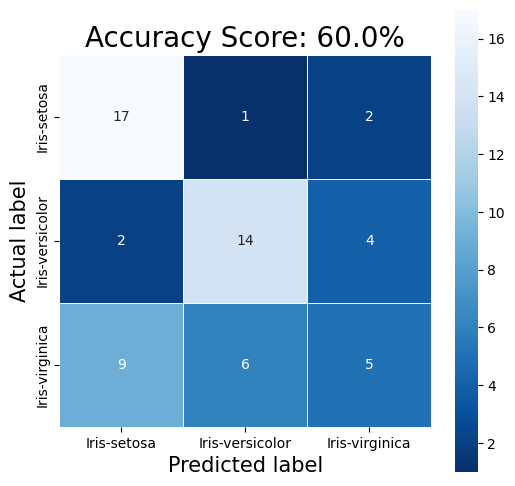

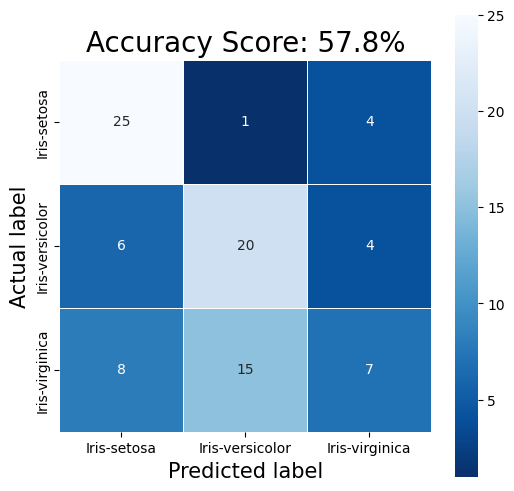

In [29]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

## Misc

### scatter plot feature v feature, color by label

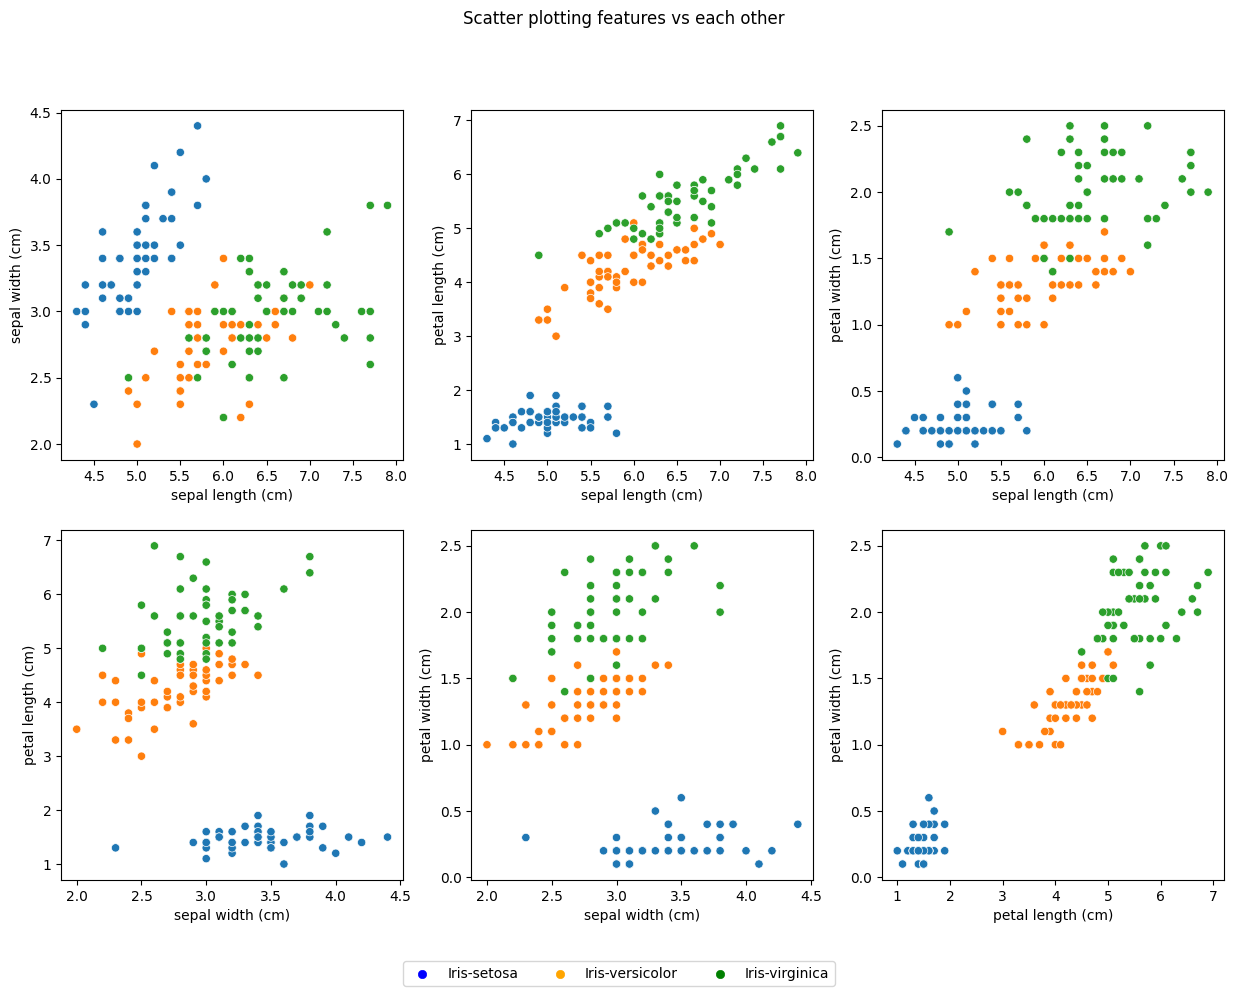

In [30]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15, 10)

cnt = 0
for i in range(4):
    for j in range(i+1, 4):
        # Use the 'hue' argument to provide a factor variable
        sns.scatterplot(ax=axs[cnt//3, cnt%3], x=iris_df.keys()[i], y=iris_df.keys()[j], data=iris_df, hue='target', legend=False)
        cnt += 1
        
# Manually set correct legend
leg = fig.legend(target_names, loc='lower center', ncol = 3)
leg.legend_handles[0].set_color('blue')
leg.legend_handles[1].set_color('orange')
leg.legend_handles[2].set_color('green')
plt.suptitle("Scatter plotting features vs each other")
plt.show()

### 3D scatterplots

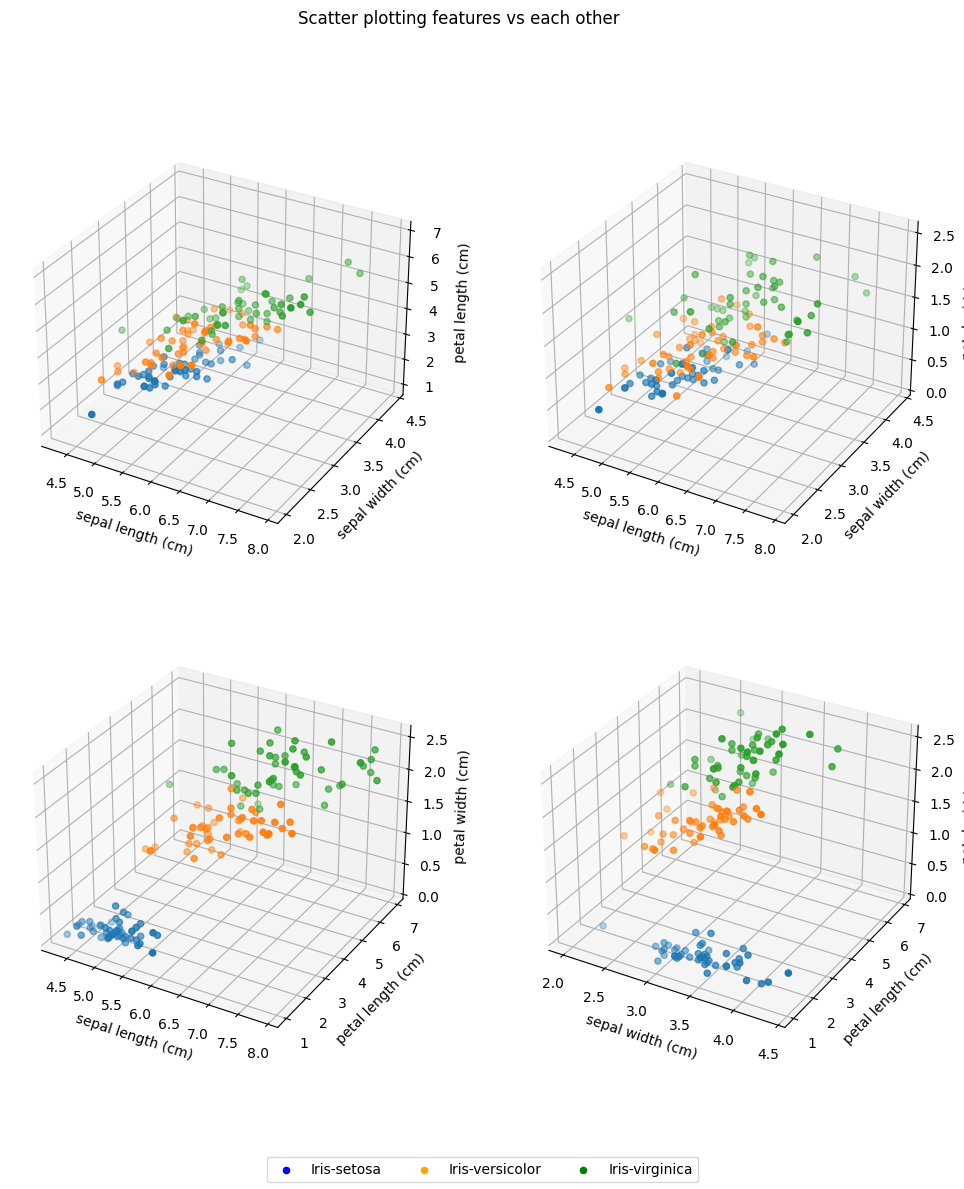

In [31]:
fig = plt.figure(figsize=(12, 12))

cnt = 0
for i in range(4):
    for j in range(i+1, 4):
        for k in range(j+1, 4):
            ax = fig.add_subplot(2, 2, cnt+1, projection='3d')
            for c in target_names:                
                ax.scatter(iris_data[iris_targets == c][:, i], iris_data[iris_targets == c][:, j], iris_data[iris_targets == c][:, k])
            ax.set_xlabel(feature_names[i])
            ax.set_ylabel(feature_names[j])
            ax.set_zlabel(feature_names[k])
            cnt += 1

# Manually set correct legend
leg = fig.legend(target_names, loc='lower center', ncol = 3)
leg.legend_handles[0].set_color('blue')
leg.legend_handles[1].set_color('orange')
leg.legend_handles[2].set_color('green')
plt.suptitle("Scatter plotting features vs each other")
plt.show()


### SKlearn classifiers for comparison

In [32]:
def linearClassification(classifier):
    name = classifier.__class__.__name__ 
    classifier.fit(training_data, training_labels)
    print("--------" + name + "--------")
   
    score = classifier.score(test_data, test_labels)
    print("Accuracy:", score*100, "%")

    return score, name

In [33]:
training_data, test_data, training_labels, test_labels = train_test_split(iris_data, iris_targets, test_size=0.4) #split the set in 3/5 training and 2/5 test

In [34]:
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import LinearSVC

classifiers = [LinearSVC(), LogisticRegression(), Perceptron(), PassiveAggressiveClassifier(), RidgeClassifier()]

scores = []
names = []

for c in classifiers:
    score, name = linearClassification(c)
    scores.append(score)
    names.append(name)

--------LinearSVC--------
Accuracy: 95.0 %
--------LogisticRegression--------
Accuracy: 96.66666666666667 %
--------Perceptron--------
Accuracy: 90.0 %
--------PassiveAggressiveClassifier--------
Accuracy: 96.66666666666667 %
--------RidgeClassifier--------
Accuracy: 73.33333333333333 %


/Users/jonaskorkosh/Documents/STUDIER/Estimering, klassifisering og deteksjon/Project/TTT4275-classification-project/myenv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
